# LFYOLO Grad-CAM notebook

This notebook loads a full PyTorch model saved as `model.pt` (full model, not state_dict),
runs it on an input image, computes a Grad-CAM heatmap for a selected detection/confidence
score, and displays the model's prediction(s) together with the heatmap overlay.

**How to use:**
1. Place `model.pt` (your full model file) and an image named `image.jpg` in the same directory.
2. Open this notebook and run cells top-to-bottom. If the classes in your model are defined in a
   local module, ensure that module is importable (same folder or in PYTHONPATH) before running.

The notebook contains robust fallbacks and helpful error messages if loading fails.


In [12]:
import ultralytics
from lf_yolo import LFYOLO_WeldDefect
from ultralytics import YOLO

In [25]:
# -------------------- MAIN: load model.pt, run Grad-CAM --------------------
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

MODEL_PATH = "model.pt"
IMAGE_PATH = "image.jpg"

try:
    # Try loading as a YOLO checkpoint
    yolo = YOLO(MODEL_PATH)
    model = yolo.model
    model.to(device).eval()
    print("✅ Loaded YOLO model successfully:", type(model))
except Exception as e:
    print(f"❌ Failed to load as YOLO checkpoint: {e}")
    print("Attempting to load as a pure PyTorch object...")

    try:
        ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=False)
        if isinstance(ckpt, dict) and "model" in ckpt:
            model = ckpt["model"]
        else:
            model = ckpt

        model.to(device).eval()
        print("✅ Fallback: loaded model.pt as PyTorch object.")
    except Exception as e2:
        print(f"❌ Both loading attempts failed: {e2}")
        model = None

torch.set_grad_enabled(True)
for p in model.parameters():
    p.requires_grad_(True)

Device: cpu
✅ Loaded YOLO model successfully: <class 'ultralytics.nn.tasks.DetectionModel'>


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os, sys, traceback

# -------------------- utilities --------------------
def find_last_conv(module):
    """Return the last nn.Conv2d module inside `module` (heuristic)."""
    last_conv = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    return last_conv

class GradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        # register hooks
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        target_layer.register_forward_hook(forward_hook)
        try:
            target_layer.register_full_backward_hook(backward_hook)
        except Exception:
            target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, score_tensor=None, target_index=None):
        """Compute CAM.
        - input_tensor: 1,C,H,W
        - score_tensor: scalar tensor to call backward() on (if None we try to create one)
        - target_index: not used if score_tensor given
        Returns: cam numpy HxW normalized 0..1
        """
        self.model.zero_grad()
        out = self.model(input_tensor)
        # If user passed a score tensor, use it; otherwise try to derive a scalar score automatically.
        if score_tensor is None:
            # Heuristic: find a tensor in `out` that contains detection confidences (last dim>=5)
            score_tensor = None
            def find_conf_scalar(o):
                # If tensor, try to pick objectness/confidence at index 4 if dim>=2
                if isinstance(o, torch.Tensor):
                    if o.numel() == 1:
                        return o.reshape(())
                    if o.ndim >= 2 and o.shape[-1] >= 5:
                        # objectness/confidence often lives in last dim position 4 on YOLO outputs
                        try:
                            confs = o[...,4]
                            # pick the top confidence as scalar
                            return confs.max()
                        except Exception:
                            pass
                    # fallback: take max absolute value
                    return o.abs().max()
                elif isinstance(o, (list, tuple)):
                    for elem in o:
                        found = find_conf_scalar(elem)
                        if found is not None:
                            return found
                return None
            score_tensor = find_conf_scalar(out)
            if score_tensor is None:
                raise RuntimeError("Could not determine a scalar score to backprop.\n"
                                   "If your model returns a custom structure, pass a score_tensor computed from outputs.")
        # Backpropagate the scalar score to get gradients
        score_tensor.backward(retain_graph=True)
        acts = self.activations  # (1,C,h,w)
        grads = self.gradients   # (1,C,h,w)
        # global average pooling of gradients -> channel weights
        weights = grads.mean(dim=(2,3), keepdim=True)  # (1,C,1,1)
        cam = (weights * acts).sum(dim=1, keepdim=True)  # (1,1,h,w)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        return cam

# image preprocessing (YOLO-style default to 640x640)
def preprocess_image(path, img_size=640, device='cpu'):
    img = Image.open(path).convert('RGB')
    orig = img.copy()
    tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    tensor = tf(img).unsqueeze(0).to(device)
    return tensor, orig

def overlay_and_show(orig_pil, cam, boxes=None, labels=None, scores=None, alpha=0.4):
    """
    Display original image, Grad-CAM heatmap, and overlay.
    boxes: list of [x1, y1, x2, y2] in either pixel or normalized (0–1) coordinates.
    """
    # Convert image to float array
    img = np.array(orig_pil).astype(np.float32) / 255.0
    W, H = orig_pil.size  # PIL gives (width, height)

    # Resize CAM to image size
    cam_resized = np.array(
        Image.fromarray((cam * 255).astype('uint8')).resize((W, H), resample=Image.BILINEAR)
    ) / 255.0

    # Prepare heatmap overlay
    cmap = plt.colormaps['jet']
    heatmap_rgb = cmap(cam_resized)[:, :, :3]
    overlay = img * (1 - alpha) + heatmap_rgb * alpha

    # --- Setup subplots ---
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[1].imshow(cam_resized, cmap='jet')
    axs[1].set_title("Grad-CAM (normalized)")
    axs[2].imshow(overlay)
    axs[2].set_title("Overlay")
    for ax in axs:
        ax.axis('off')

    # --- Draw bounding boxes (if any) ---
    if boxes is not None and len(boxes) > 0:
        print("Drawing boxes on images : ", boxes)

        for ax in axs:
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     edgecolor='lime', linewidth=2, fill=False)
                ax.add_patch(rect)

                # Label + score (if available)
                if labels is not None and scores is not None:
                    caption = f"{labels[i]} {scores[i]:.2f}"
                    ax.text(x1, max(0, y1 - 8), caption,
                            fontsize=9, color='black',
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.tight_layout()
    plt.show()



Using target conv layer: Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
Grad-CAM computed.


C:\Users\Admin\AppData\Local\Temp\ipykernel_35340\3447502925.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet')


Drawing boxes on images :  [[np.float32(1.1417409), np.float32(0.30386627), np.float32(3.3923101), np.float32(3.4004068)], [np.float32(4.770074), np.float32(2.8619719), np.float32(11.008237), np.float32(8.364259)], [np.float32(2.2000504), np.float32(2.444121), np.float32(7.245389), np.float32(7.465978)]]


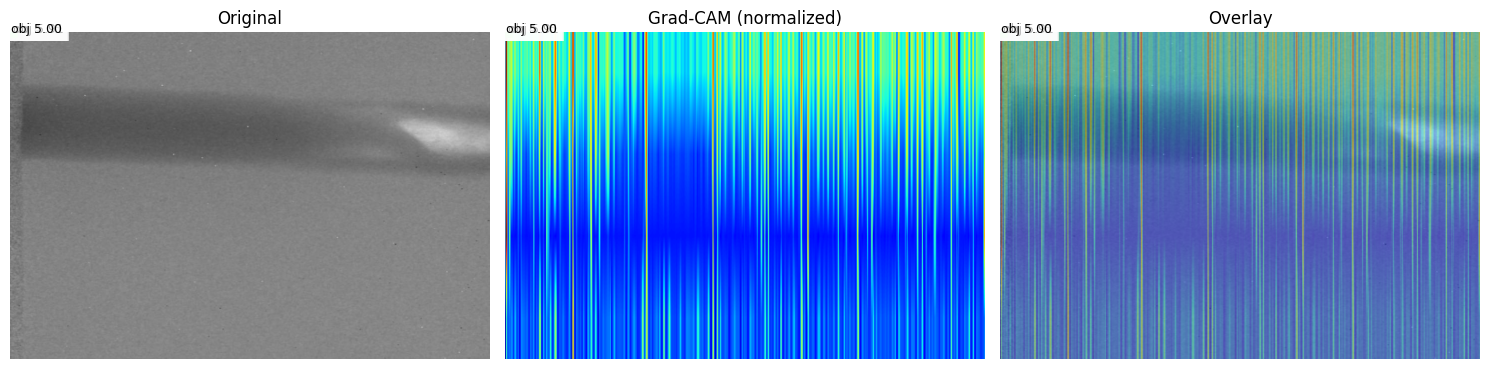

Detected boxes (heuristic parsing):
 - obj 4.046 bbox=[np.float32(1.1417409), np.float32(0.30386627), np.float32(3.3923101), np.float32(3.4004068)]
 - obj 5.909 bbox=[np.float32(4.770074), np.float32(2.8619719), np.float32(11.008237), np.float32(8.364259)]
 - obj 5.002 bbox=[np.float32(2.2000504), np.float32(2.444121), np.float32(7.245389), np.float32(7.465978)]


In [35]:
input_tensor, orig_pil = preprocess_image(IMAGE_PATH, img_size=640, device=device)

# find a target convolutional layer (heuristic)
target_layer = find_last_conv(model)
if target_layer is None:
    raise RuntimeError('No Conv2d found in the model (cannot run Grad-CAM automatically).')
print('Using target conv layer:', target_layer)

gradcam = GradCAM(model, target_layer)
# run a forward pass and let GradCAM attempt to pick a scalar score from outputs
try:
    input_tensor.requires_grad_(True)
    cam = gradcam.generate_cam(input_tensor)
    print('Grad-CAM computed.')
except Exception as e:
    print('Failed to compute Grad-CAM automatically:', e)
    traceback.print_exc()
    cam = None

# Run model forward to get predictions for display (best-effort)
try:
    with torch.no_grad():
        outputs = model(input_tensor)
except Exception as e:
    print('Failed to run model forward for predictions:', e)
    outputs = None

# Heuristic: if outputs contain detections in YOLO format, try to extract boxes/classes/scores for display
boxes, labels, scores = [], [], []
if outputs is not None:
    # find first tensor in outputs
    def find_tensor(o):
        if isinstance(o, torch.Tensor):
            return o
        if isinstance(o, (list,tuple)):
            for elem in o:
                t = find_tensor(elem)
                if t is not None:
                    return t
        return None
    t = find_tensor(outputs)
    if t is not None and t.ndim >= 2:
        # Heuristic: treat t as (N, M) or (1, M, dims); flatten to 2D
        arr = t.detach().cpu().numpy()
        # try to interpret last dimension as [x,y,w,h,conf, class0..] or standard YOLO
        if arr.ndim == 3:
            arr2 = arr[0]
        else:
            arr2 = arr.reshape(-1, arr.shape[-1])
        # if last dim >=6, attempt to parse: x,y,w,h,conf,cls
        if arr2.shape[1] >= 6:
            # treat columns: x_center,y_center,w,h,conf,cls
            for row in arr2:
                conf = float(row[4])
                cls = int(row[5]) if row[5] == int(row[5]) else None
                if conf > 0.3:
                    # convert center to xyxy using original image size
                    xc, yc, w, h = row[0], row[1], row[2], row[3]
                    # if xc,yc appear to be normalized (0..1) scale to orig image
                    ow, oh = orig_pil.size
                    if xc <= 1.0 and yc <= 1.0 and w <= 1.0 and h <= 1.0:
                        x1 = (xc - w/2) * ow
                        y1 = (yc - h/2) * oh
                        x2 = (xc + w/2) * ow
                        y2 = (yc + h/2) * oh
                    else:
                        # assume absolute coords
                        x1 = xc - w/2; y1 = yc - h/2; x2 = xc + w/2; y2 = yc + h/2
                    boxes.append([x1,y1,x2,y2])
                    labels.append(str(cls) if cls is not None else 'obj')
                    scores.append(conf)
        else:
            # fallback: not parsable as boxes; skip
            pass

# display results
if cam is not None:
    overlay_and_show(orig_pil, cam, boxes=boxes, labels=labels, scores=scores)
else:
    print('No CAM to display.')
if boxes:
    print('Detected boxes (heuristic parsing):')
    for b,l,s in zip(boxes, labels, scores):
        print(f' - {l} {s:.3f} bbox={b}')
else:
    print('No detection boxes parsed from the model outputs (format may differ).')


In [33]:
for box in boxes:
    print(max(box))

3.4004068
11.008237
7.465978


## Notes & troubleshooting

"
- If `torch.load('model.pt')` fails with `AttributeError: Can't get attribute ...`, it means the class definition
  for your model (or sub-classes) is not importable. Put the module that defines those classes next to this notebook
  or add it to `PYTHONPATH` before running.

- Grad-CAM for object detectors is heuristic: the notebook tries to pick a scalar score (top detection confidence). For
  precise control, compute the scalar score corresponding to the exact detection you want (e.g., the confidence of a
  specific bbox) and pass it into `GradCAM.generate_cam(..., score_tensor=that_tensor)` to backprop that exact decision.

- If you want separate CAMs for "primary" vs "ghost" channels in your custom GhostConv block, use the captured
  `gradcam.activations` and `gradcam.gradients` tensors and split them by channel index to compute per-group CAMs.

- Save the notebook and run it locally where your model and images exist. The file saved by this script is:

  `/mnt/data/gradcam_yolo_notebook.ipynb`

Enjoy!
